In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [5]:
context = ingestor.Context("runs/minimal6.2.run")

In [6]:
solver = fitter.Fitter(context)

In [7]:
for rhoi in np.logspace(-6, 3, num=51):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [8]:
solver.solutions

{'1e-06': [      fun: 0.01194180467107653
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-1.97932676e-13,  4.68287333e-13,  8.93138183e-13, -6.55243091e-14,
          1.24710509e-12, -5.42786783e-12, -2.65707871e-12, -8.67363515e-12,
          1.93625470e-12, -6.43116648e-13, -7.39325125e-12])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 3
        nit: 2
     status: 0
    success: True
          x: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 '1.5135612484362072e-06': [      fun: 0.01194180467107653
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-3.16384506e-13,  4.07452975e-13,  1.82936984e-13,  1.46571880e-12,
          4.11694395e-13, -3.26603920e-12,  5.57804860e-13, -2.88026423e-11,
          4.83798574e-12,  2.96819255e-12, -9.83420237e-12])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 1
        nit: 0
     status: 0
    success: True
    

# Validation

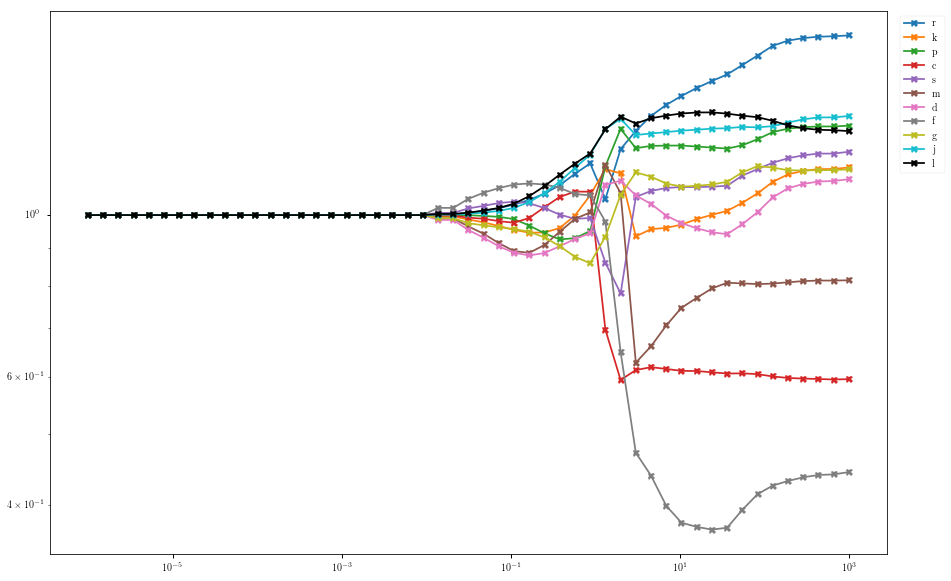

In [9]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0, 0.5, 'Number')

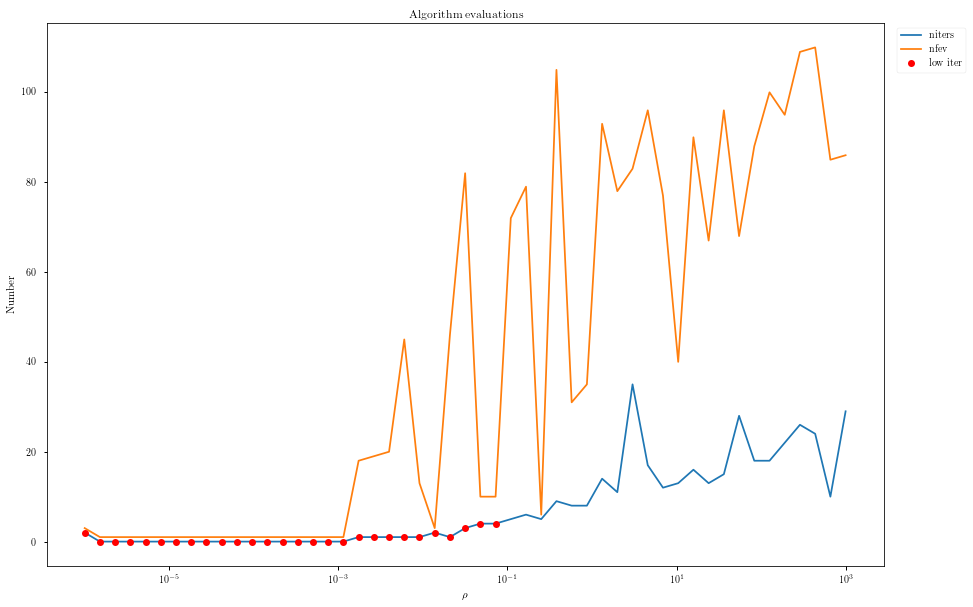

In [10]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [11]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [solver.models[0].ts, *solver.models[0].cs], solver.models[0].xs)
    

[1.36858752 0.95641171 1.24456435 0.61798396 1.07919109 0.66026859
 1.03570365 0.43846623 1.12917387 1.2944122  1.35840691]
[[-6.31047594e-05  5.40815866e-01 -4.33531030e-01]]


Text(0.5, 0, 'time, t')

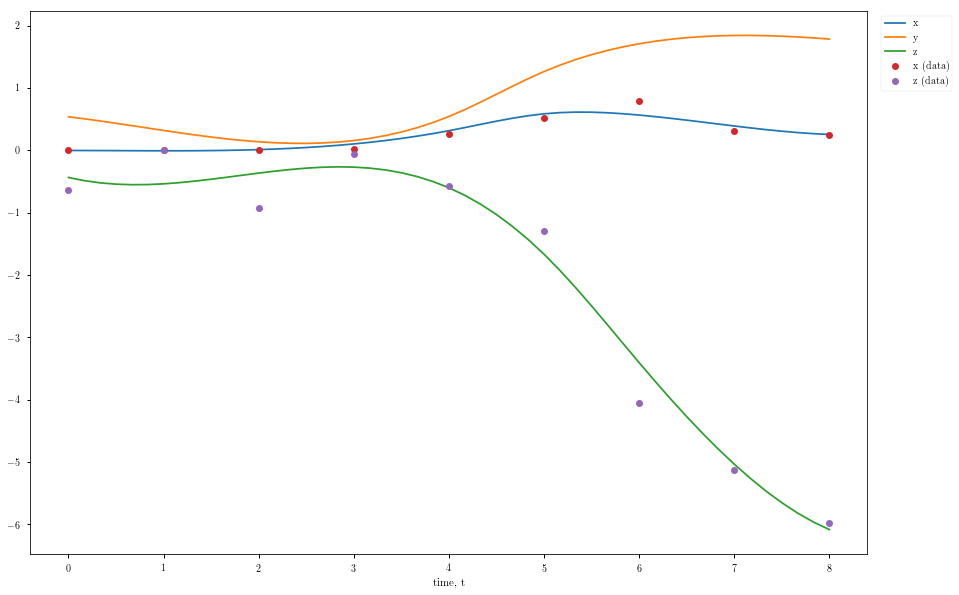

In [12]:
target_rho = 4.570881896148752
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(solver.models[0].observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
plt.plot(solver.models[0].observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

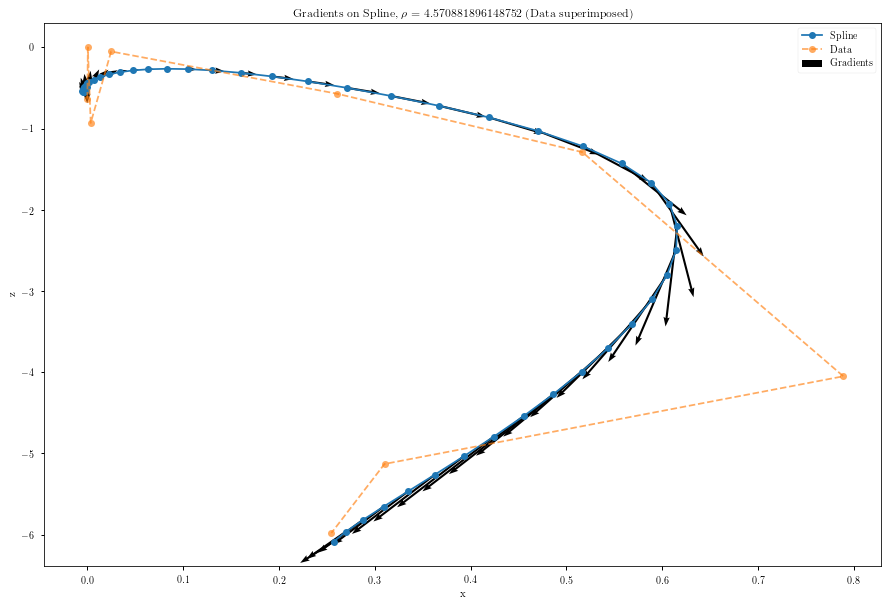

In [13]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(solver.models[0].observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

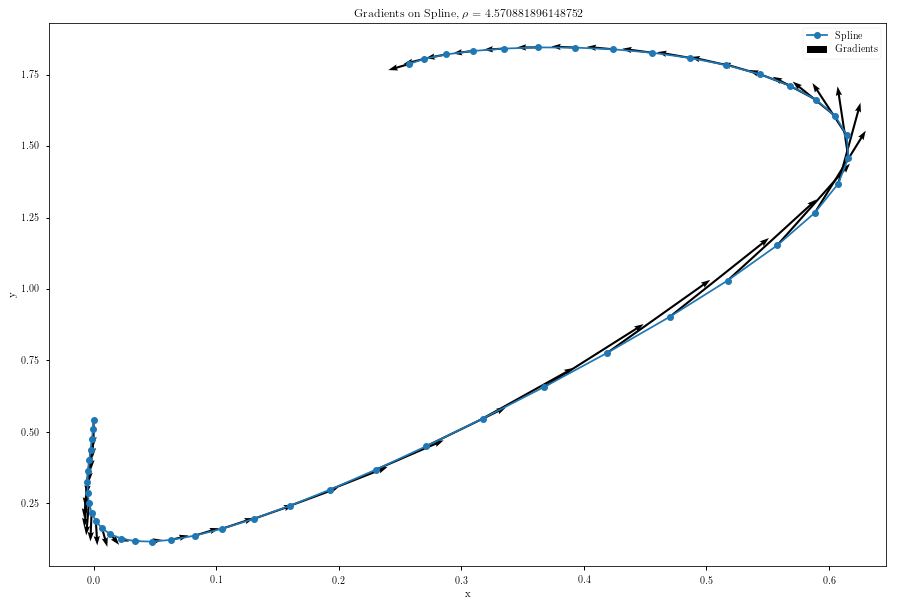

In [14]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

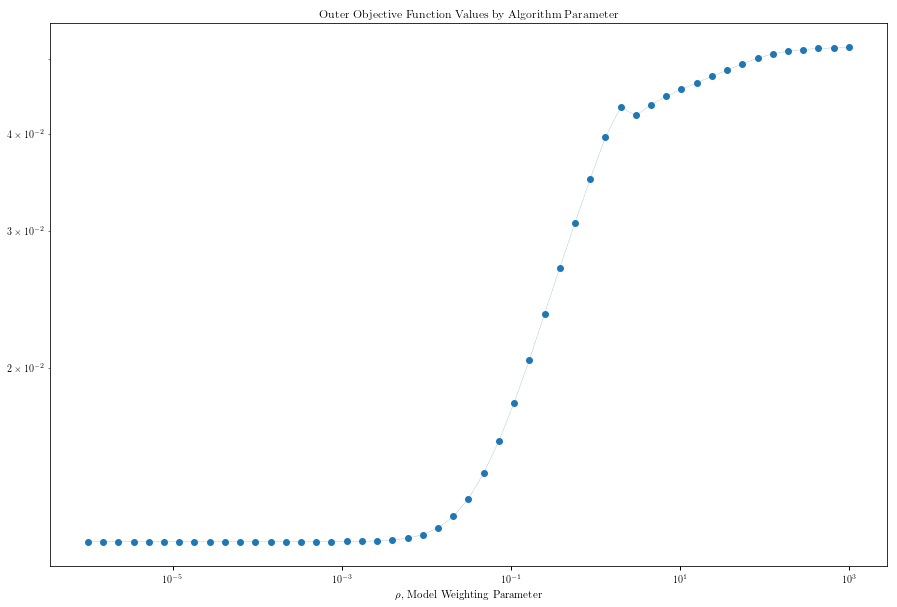

In [15]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o--', linewidth=0.25)
plt.title("Outer Objective Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

In [16]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.abs(np.hstack([np.array(rhos).reshape(-1,1), 
                           ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)]))


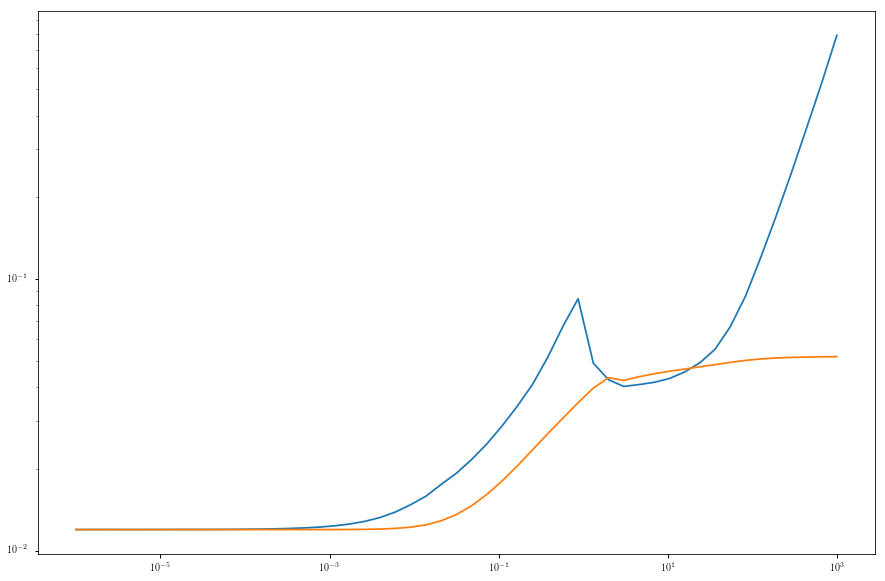

In [17]:
plt.loglog(*inner_objective_values.T, *outer_objective_values.T)

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

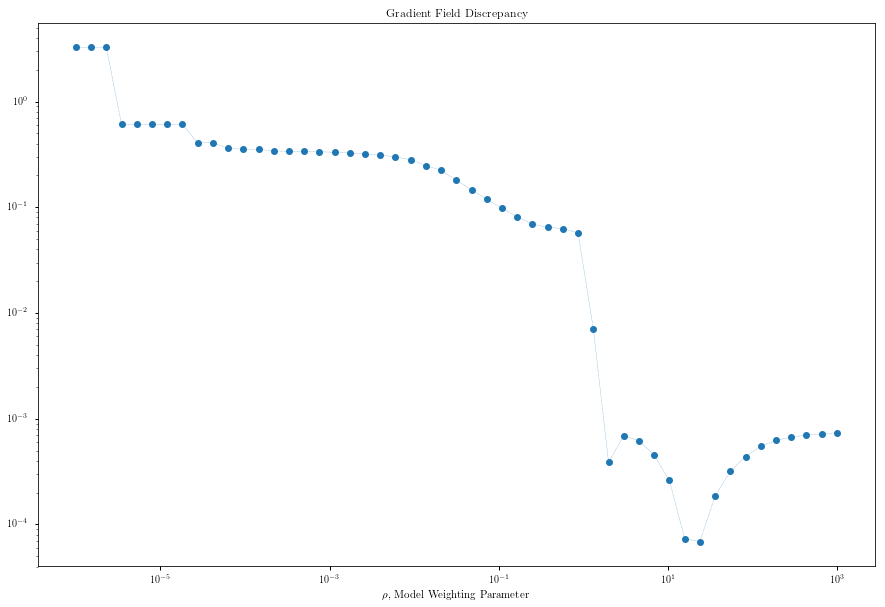

In [18]:
plt.loglog(*dfield.T, 'o--', linewidth=0.25)
plt.title("Gradient Field Discrepancy")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0, 0.5, 'Diff Field')

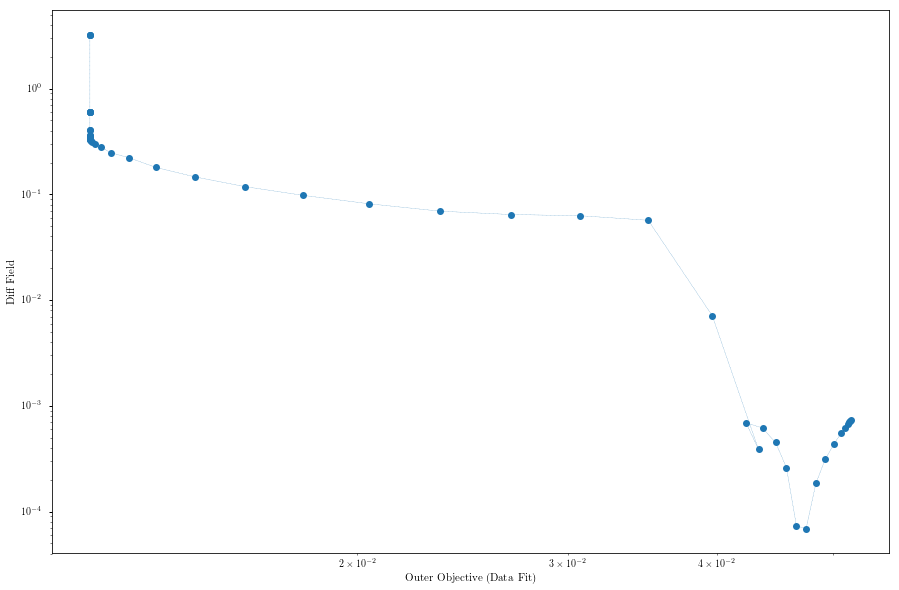

In [19]:
plt.loglog(outer_objective_values[:,1], dfield[:,1], '--o', linewidth=0.25)
plt.xlabel("Outer Objective (Data Fit)")
plt.ylabel("Diff Field")

Text(0, 0.5, '$\\kappa$')

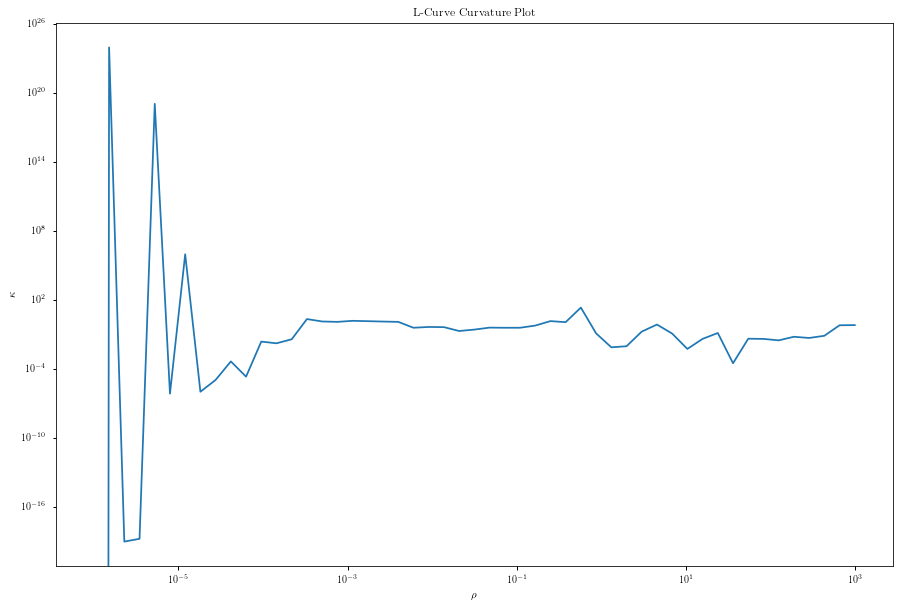

In [20]:
curv_dx = np.gradient(np.log(outer_objective_values[:,1]))
curv_dy = np.gradient(np.log(dfield[:,1]))
curv_dx2 = np.gradient(curv_dx)
curv_dy2 = np.gradient(curv_dy)

kappa = np.abs(curv_dx*curv_dy2 - curv_dy*curv_dx2)/(curv_dx**2 + curv_dy**2)**(3/2)

plt.loglog(rhos, kappa)
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\kappa$")

## Odd Validation

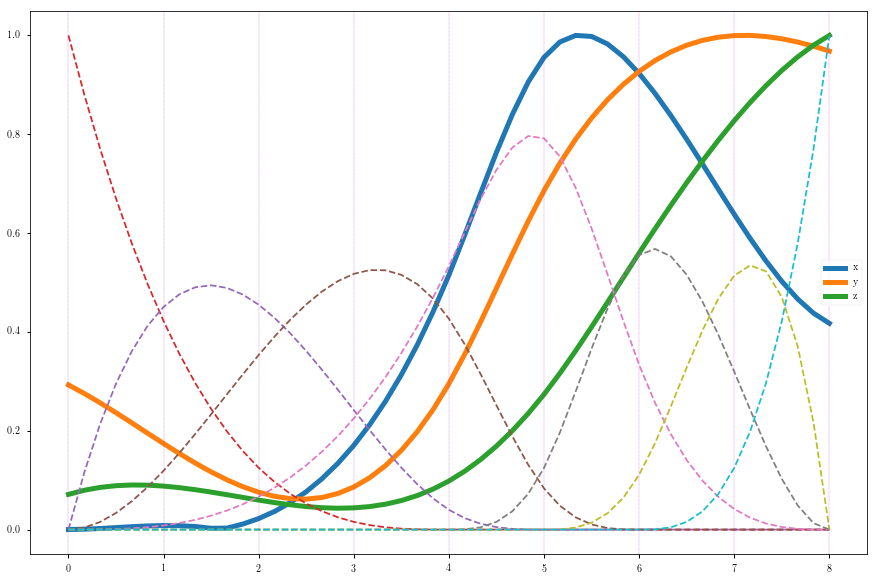

In [21]:
bfn = modeller.ca.Function('basis_fns', [solver.models[0].ts], [solver.models[0].basis])
plt.plot(solver.models[0].observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=5)
plt.plot(solver.models[0].observation_times, bfn(solver.models[0].observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

In [22]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

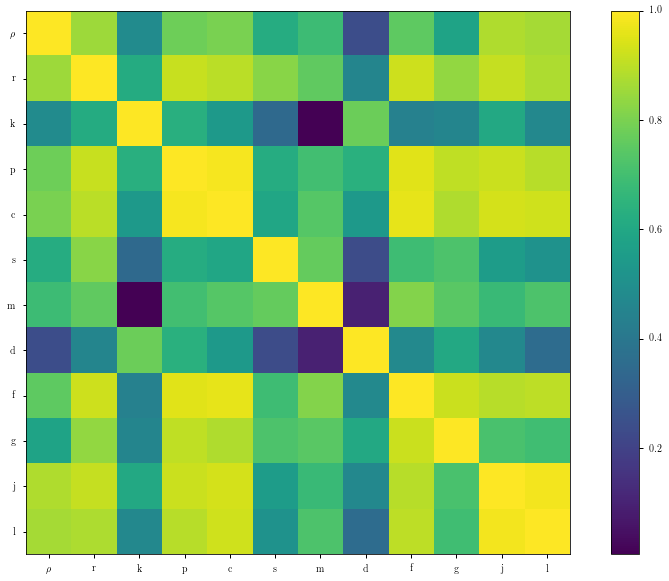

In [23]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

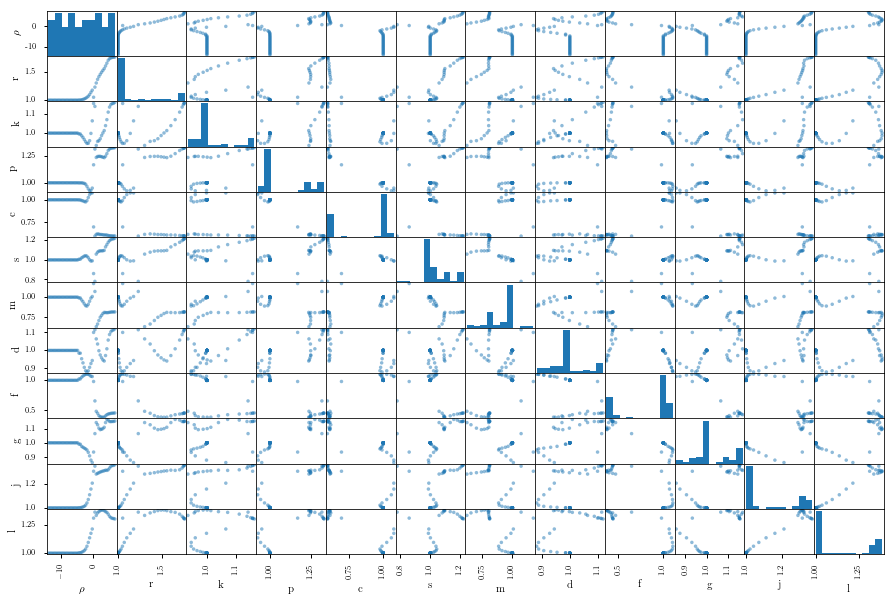

In [24]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

## Smoothing Experiments

In [25]:
from scipy import interpolate

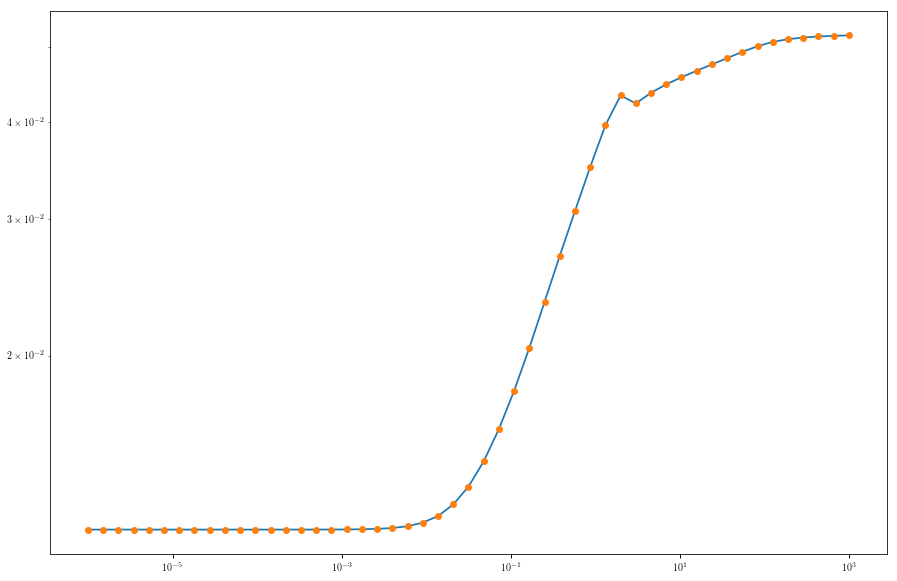

In [26]:
smooth_outer = interpolate.make_interp_spline(np.log10(rhos), np.log10(outer_objective_values[:,1]),)
souter =  np.array([10**x for x in smooth_outer(np.log10(rhos))])
plt.loglog(rhos, souter, rhos, outer_objective_values[:,1], 'o')

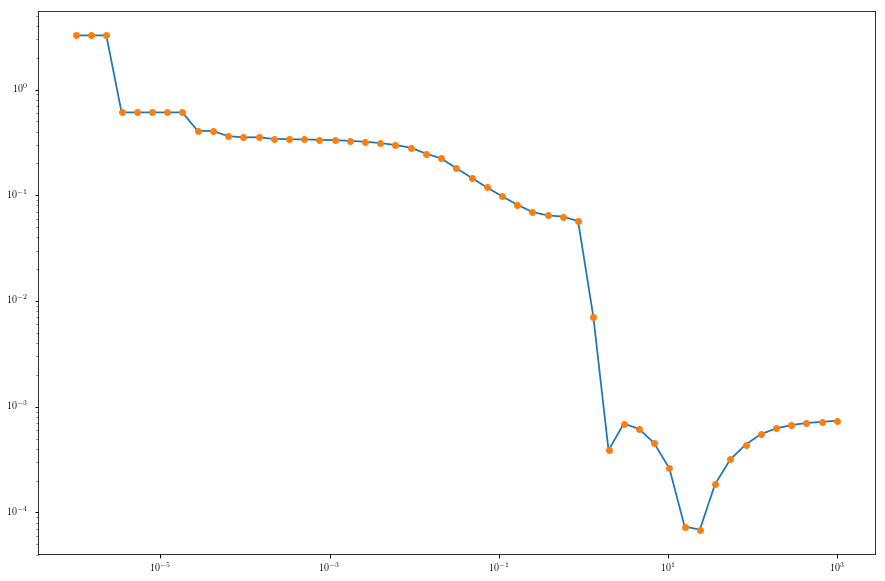

In [27]:
smooth_dfield = interpolate.make_interp_spline(np.log10(rhos), np.log10(dfield[:,1]))
sfield =  np.array([10**x for x in smooth_dfield(np.log10(rhos))])
plt.loglog(rhos, sfield, rhos, dfield[:,1], 'o')

In [28]:
rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)
sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)
plottable_sx = 10**sx
plottable_sy = 10**sy

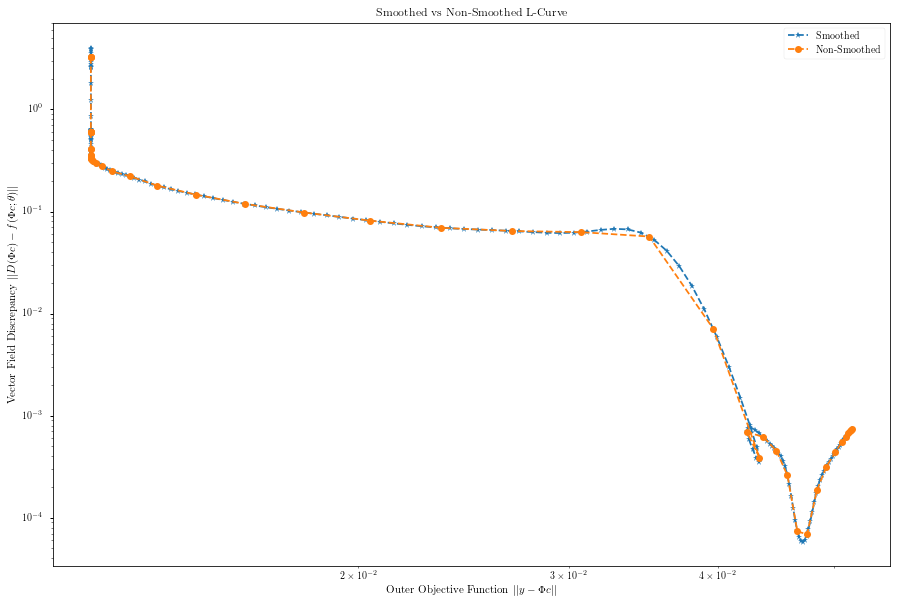

In [29]:
plt.loglog(plottable_sx, plottable_sy, '*--', outer_objective_values[:,1], dfield[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Outer Objective Function $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

Text(0, 0.5, '$\\kappa$')

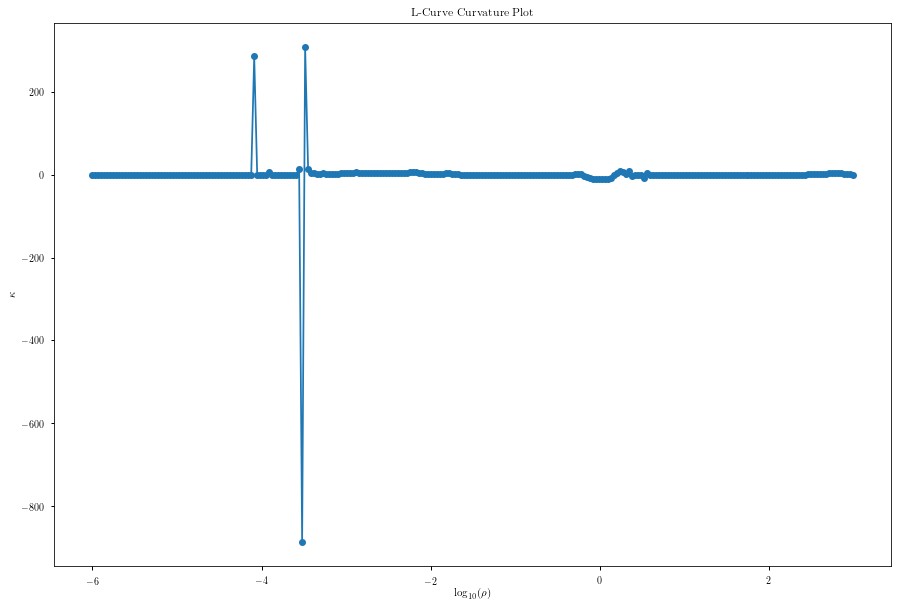

In [30]:
# ? curvature
f_dx = smooth_outer.derivative(1)
f_dy = smooth_dfield.derivative(1)
f_dx2 = smooth_outer.derivative(2)
f_dy2 = smooth_dfield.derivative(2)

scurv_dx = f_dx(rhos_log_finer)
scurv_dy = f_dy(rhos_log_finer)
scurv_dx2 = f_dx2(rhos_log_finer)
scurv_dy2 = f_dy2(rhos_log_finer)

kappa_fine = scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2/(scurv_dx**2 + scurv_dy**2)**(3/2)

plt.plot(rhos_log_finer, kappa_fine, 'o-')
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

Text(0, 0.5, '$\\kappa$')

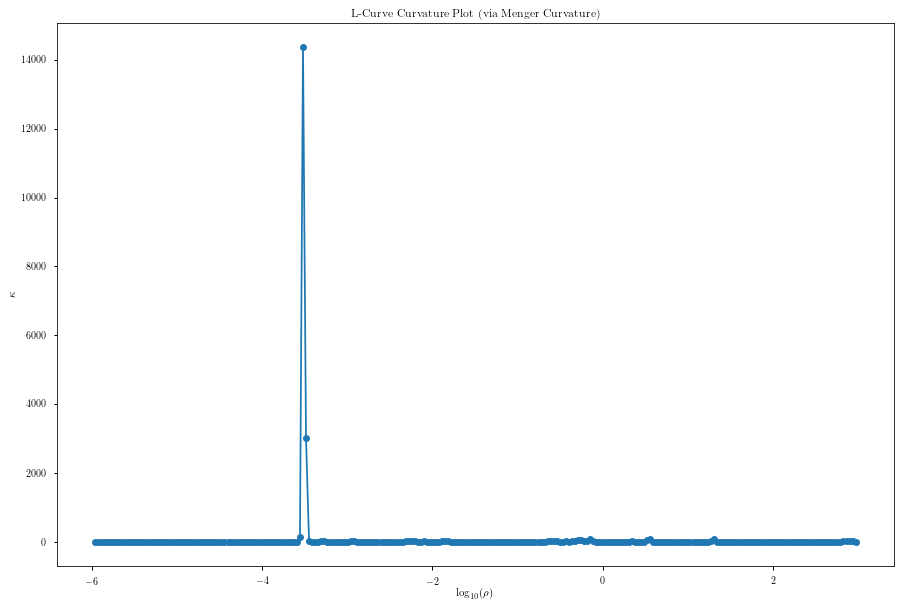

In [31]:
# menger curvature
curvs = []

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.plot(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

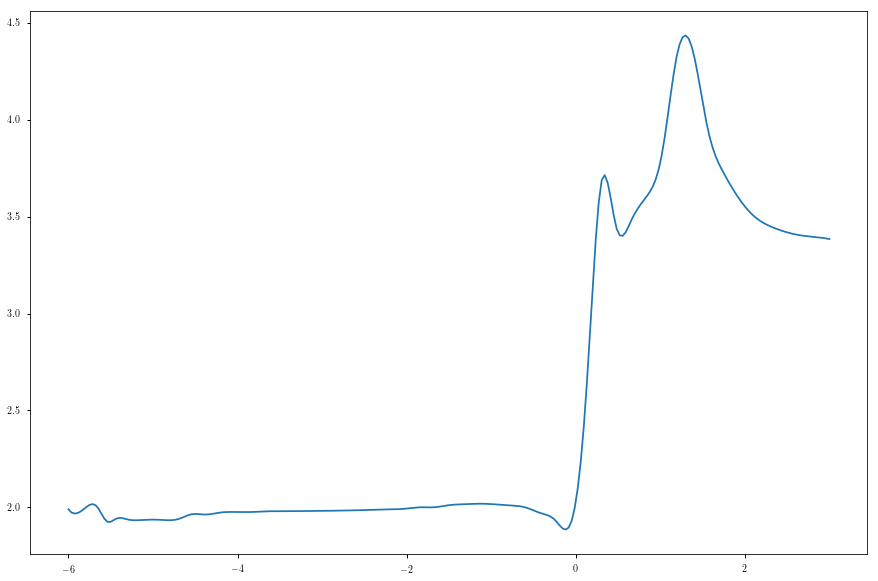

In [32]:
# implement the heuristic measurement
origin  = (0,0)
xy = np.array(list(zip(sx, sy)))
distances = [np.linalg.norm(xyi) for xyi in xy]
plt.plot(rhos_log_finer, distances)

0.05891649027311915 : 0.06606499872330636
0.30707409678822156 : 0.2163658168196548


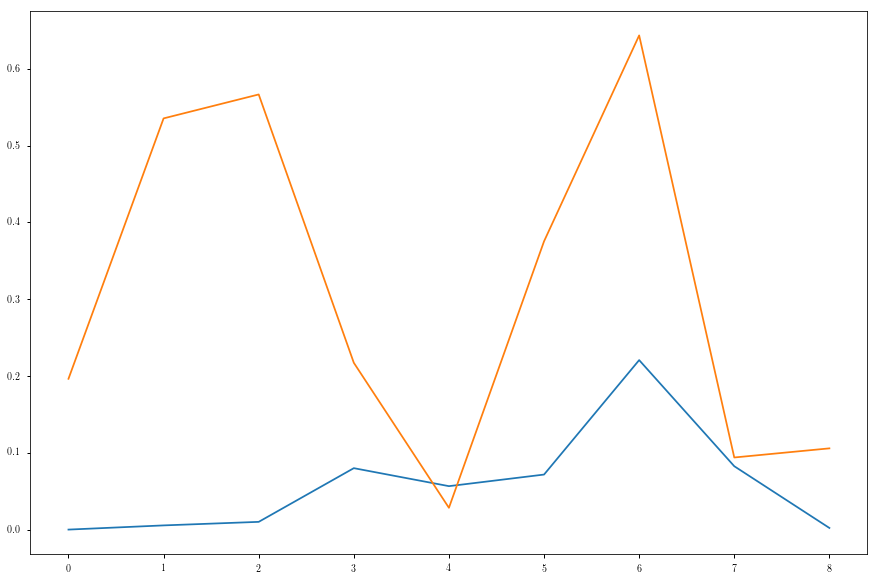

In [33]:
observable_x = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[0]
observable_z = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[2]

x_err = np.abs(observable_x.T - np.array(context.datasets[0]['x'])).reshape(-1,)
z_err = np.abs(observable_z.T - np.array(context.datasets[0]['z'])).reshape(-1,)

t = np.array(context.datasets[0]['t'])

plt.plot(t, x_err, t, z_err)
print(f"{np.mean(x_err)} : {np.std(x_err)}")
print(f"{np.mean(z_err)} : {np.std(z_err)}")


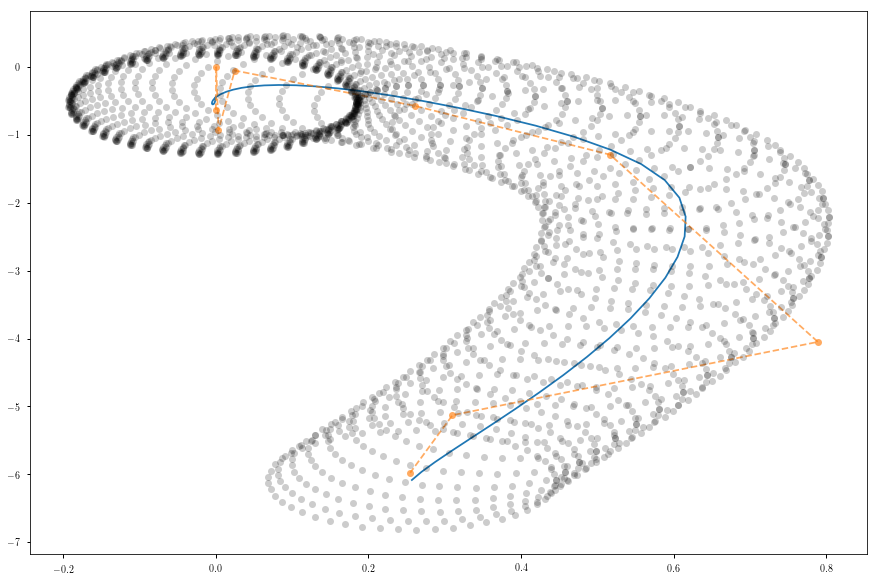

In [34]:
x0, y0 = xs_end[[0,2], :]
xscale = np.mean(x_err) + 1.96*np.std(x_err)
zscale = np.mean(z_err) + 1.96*np.std(z_err)
circle_x, circle_y = [x0 + xscale*np.cos(np.linspace(0, 2*np.pi, 50)), y0 + zscale*np.sin(np.linspace(0, 2*np.pi, 50))]

plt.plot(xs_end[0], xs_end[2])
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.plot(circle_x, circle_y, 'ko', alpha=0.2)
print('')


In [35]:
## Use menger curvature to estimate the "ideal" parameter
maximus = 10**rhos_log_finer[np.argmax(curvs)+1]
print(f"{maximus}\n is the spike")
closest_rho = rhos[np.argmin(np.abs(rhos-maximus))]
print(f"{closest_rho}\n is the closest")

0.00030221426551783794
 is the spike
0.0003311311214825911
 is the closest


In [36]:
solver.solutions

{'1e-06': [      fun: 0.01194180467107653
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-1.97932676e-13,  4.68287333e-13,  8.93138183e-13, -6.55243091e-14,
          1.24710509e-12, -5.42786783e-12, -2.65707871e-12, -8.67363515e-12,
          1.93625470e-12, -6.43116648e-13, -7.39325125e-12])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 3
        nit: 2
     status: 0
    success: True
          x: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 '1.5135612484362072e-06': [      fun: 0.01194180467107653
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-3.16384506e-13,  4.07452975e-13,  1.82936984e-13,  1.46571880e-12,
          4.11694395e-13, -3.26603920e-12,  5.57804860e-13, -2.88026423e-11,
          4.83798574e-12,  2.96819255e-12, -9.83420237e-12])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 1
        nit: 0
     status: 0
    success: True
    

In [37]:
rhos

[1e-06,
 1.5135612484362072e-06,
 2.2908676527677747e-06,
 3.467368504525317e-06,
 5.248074602497723e-06,
 7.943282347242822e-06,
 1.2022644346174132e-05,
 1.8197008586099827e-05,
 2.7542287033381633e-05,
 4.168693834703355e-05,
 6.309573444801929e-05,
 9.549925860214369e-05,
 0.0001445439770745928,
 0.00021877616239495518,
 0.0003311311214825911,
 0.000501187233627272,
 0.0007585775750291835,
 0.0011481536214968829,
 0.0017378008287493745,
 0.0026302679918953813,
 0.003981071705534969,
 0.006025595860743574,
 0.009120108393559097,
 0.013803842646028838,
 0.02089296130854041,
 0.03162277660168379,
 0.0478630092322638,
 0.07244359600749892,
 0.1096478196143185,
 0.16595869074375597,
 0.2511886431509577,
 0.38018939632056126,
 0.5754399373371566,
 0.8709635899560796,
 1.3182567385564075,
 1.9952623149688788,
 3.019951720402013,
 4.570881896148752,
 6.918309709189363,
 10.471285480508985,
 15.84893192461111,
 23.9883291901949,
 36.3078054770101,
 54.95408738576237,
 83.17637711026708,
 12